## Team Schedule Plan

| Day       | Task                                                                    |
| --------- | ----------------------------------------------------------------------- |
| **Day 1** | Set up environment skeleton (Gym-compatible)                            |
| **Day 2** | Implement simulator: synthetic or LOB-based market                      |
| **Day 3** | Add SAC with stable-baselines3 + training loop                          |
| **Day 4** | Tune rewards (e.g., inventory risk penalty, cost)                       |
| **Day 5** | Run training, collect plots, evaluate vs VWAP/TWAP                      |
| **Day 6** | Polish results: plots, metrics, ablation (e.g., high vs low volatility) |
| **Day 7** | Finalize slides + notebook/code repo for presentation                   |


## **Optimal Trade Execution using Soft Actor-Critic (SAC) in a Realistic Limit Order Book Simulator**

#### **Project Goal**

Simulate the behavior of a trader executing a large order (buy or sell) over a short time horizon (like 60 minutes), and use Soft Actor-Critic (SAC) to minimize execution cost while respecting market impact and inventory risk.

#### **SAC Review**

Literature review about SAC

#### **Environment**

Build or use a Gym-style custom environment with:

- state: window of historical mid-prices, spread, inventory, time left

- action: % of remaining order to execute now (continuous: 0–1)

- reward: negative cost (slippage + penalty for unfilled inventory)

Bonus realism:

- Add adverse selection penalty (price moves against you if you trade aggressively)

- Use synthetic LOB data (mid-price + random walk) or Lobster

#### **RL Agent**

Train a Soft Actor-Critic (SAC) agent to:

- Learn a trade-off between trading speed and cost

- Adapt to different market volatility levels

- Beat a baseline (e.g., VWAP or TWAP)

#### **Evaluation**

Compare SAC vs baselines on:

- Execution cost

- Remaining inventory

- Price slippage

- Reward curve over episodes

#### **Code**

**Install Required Libraries**

In [ ]:
pip install stable-baselines3[extra] gym numpy matplotlib


**Custom Trading Environment**

In [47]:
import gym
from gym import spaces
import numpy as np
import random
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

class ExecutionEnv(gym.Env):
    def __init__(self, total_steps=60, total_inventory=1000, spread=0.02):
        super(ExecutionEnv, self).__init__()

        self.total_steps = total_steps
        self.total_inventory = total_inventory
        self.remaining_inventory = total_inventory
        self.spread = spread  # 2 cent spread for a $100 stock

        self.current_step = 0
        self.price_series = self._generate_price_series()

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32  # price, inventory, time, volatility
        )

        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
    
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]


    def _generate_price_series(self):
        # Simulate a random walk price series starting at 100
        prices = [100]
        for _ in range(self.total_steps):
            prices.append(prices[-1] + np.random.normal(0, 0.2))  # 20c volatility
        return np.array(prices)

    def _get_observation(self):
        price = self.price_series[self.current_step]
        time_fraction = 1 - self.current_step / self.total_steps
        inventory_fraction = self.remaining_inventory / self.total_inventory
        volatility = np.std(self.price_series[max(0, self.current_step - 5):self.current_step + 1])
        return np.array([price, inventory_fraction, time_fraction, volatility], dtype=np.float32)

    def reset(self):
        self.price_series = self._generate_price_series()
        self.remaining_inventory = self.total_inventory
        self.current_step = 0
        return self._get_observation()

    def step(self, action):
        # action ∈ [0, 1] representing % of remaining inventory to execute this step
        action = np.clip(action, 0, 1)[0]
        executed_volume = action * self.remaining_inventory
        self.remaining_inventory -= executed_volume

        # Execute at the ask (we are buying)
        mid_price = self.price_series[self.current_step]
        ask_price = mid_price + self.spread / 2

        # Cost is price * volume
        cost = executed_volume * ask_price

        self.current_step += 1
        done = self.current_step >= self.total_steps or self.remaining_inventory <= 0

        # Reward is negative cost; add penalty for unexecuted inventory
        reward = -cost
        if done and self.remaining_inventory > 0:
            penalty = self.remaining_inventory * (mid_price + self.spread) * 1.5  # force-fulfill penalty
            reward -= penalty

        return self._get_observation(), reward, done, {}

    def render(self, mode='human'):
        print(f"Step {self.current_step} - Remaining Inventory: {self.remaining_inventory}")




**Train SAC Agent**

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env


# Wrap the environment
env = make_vec_env(lambda: ExecutionEnv(), n_envs=1, seed=42)

# Create SAC model
model = SAC("MlpPolicy", env, verbose=1, seed=42)
model.learn(total_timesteps=20000)

# Save
model.save("sac_execution_agent")


/home/sobottka/anaconda3/envs/DL/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 60       |
|    ep_rew_mean     | -1e+05   |
| time/              |          |
|    episodes        | 4        |
|    fps             | 129      |
|    time_elapsed    | 1        |
|    total_timesteps | 240      |
| train/             |          |
|    actor_loss      | 1.1e+03  |
|    critic_loss     | 2.75e+07 |
|    ent_coef        | 0.968    |
|    ent_coef_loss   | -0.047   |
|    learning_rate   | 0.0003   |
|    n_updates       | 139      |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 60        |
|    ep_rew_mean     | -1.01e+05 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 100       |
|    time_elapsed    | 4         |
|    total_timesteps | 480       |
| train/             |           |
|    actor_loss      | 2.87e+03  |
|    critic_loss    

**Evaluation + VWAP Benchmark**

SAC Execution Total Cost: $146953.55
VWAP Cost (baseline):     $99140.38


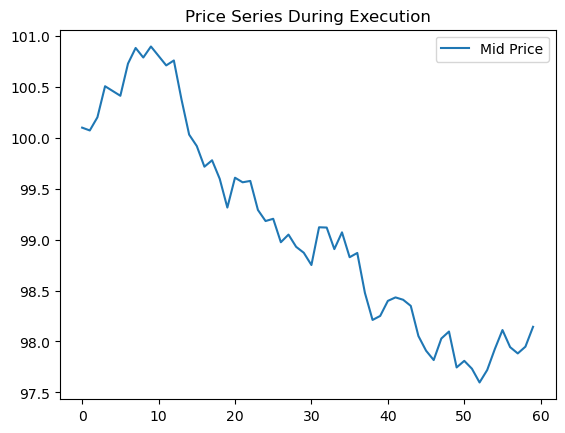

In [56]:
import matplotlib.pyplot as plt


env = ExecutionEnv()
model = SAC.load("sac_execution_agent")

obs = env.reset()
total_cost = 0
executed_volume = 0
costs = []
prices = []

while True:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)
    mid = env.price_series[env.current_step]
    ask = mid + env.spread / 2
    costs.append(-reward)
    prices.append(mid)
    if done:
        break

# VWAP Benchmark
vwap_cost = sum(env.price_series[i] + env.spread / 2 for i in range(env.total_steps)) * env.total_inventory / env.total_steps

print(f"SAC Execution Total Cost: ${sum(costs):.2f}")
print(f"VWAP Cost (baseline):     ${vwap_cost:.2f}")

plt.plot(prices, label="Mid Price")
plt.title("Price Series During Execution")
plt.legend()
plt.show()


#### **Output (Report)**

- Motivation: Execution is the backbone of quant trading

- Problem: Minimize cost for large orders

- RL Model: SAC on market simulator

- Results: Cost reduction vs baselines

- Insight: RL learns smart pacing; adapts to market regime

In this project, I develop a Soft Actor-Critic (SAC) agent to learn optimal trade execution strategies in a simulated limit order book environment. The agent minimizes execution costs and risk while trading over short horizons. Compared to VWAP and TWAP benchmarks, the SAC agent shows superior adaptability under market volatility and slippage constraints

#### **Next Steps & Add-ons**

| Feature                          | Code Needed? | Value                    |
| -------------------------------- | ------------ | ------------------------ |
| Inventory penalty tune           | Yes          | More risk-aware behavior |
| Market regime switching          | Small tweak  | Show SAC adaptability    |
| Add short-selling (sell orders)  | Moderate     | Add realism              |
| Real price data (e.g., BTC, ETH) | Minor change | Realistic simulation     |
| Multi-agent environment          | Advanced     | Simulate market response |
